# 0. Preparation

In [4]:
import numpy as np
import heapq
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## 0.1. load data

In [5]:
# 資料位置設置
data_path = "../data/ratings.data"

# 讀取資料
data = np.loadtxt(data_path, dtype=int)
print(data.shape)
print(data[:5])

(100000, 4)
[[      196       242         3 881250949]
 [      186       302         3 891717742]
 [       22       377         1 878887116]
 [      244        51         2 880606923]
 [      166       346         1 886397596]]


In [6]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])
print(user.shape, movie.shape)

(943,) (1682,)


## 0.2. split training data & testing data

In [7]:
# 將資料切分為訓練資料及測試資料
train_data, test_data = train_test_split(data, test_size = 0.25, random_state=42)
print(train_data.shape, test_data.shape)

(75000, 4) (25000, 4)


# 1. Collaborative Filtering (CF)

In [152]:
# 針對向量非0地方做計算
def non_zero_mean(arr):
    exist = arr != 0
    total = arr.sum(axis = 1)
    exist_number = exist.sum(axis=1)
    
    return np.reshape(total/exist_number, (-1, 1))

# 針對單一向量非0地方做計算
def non_zero_vec_mean(vec):
    exist = vec != 0
    total = vec.sum()
    if total == 0: return 0
    exist_number = exist.sum()
    
    return total/exist_number


# 取得整體平均
def get_u():    
    return np.mean(non_zero_mean(user_matrix))
    
    
# 計算向量長度
def norm(v):
    return np.sqrt(np.sum(np.power(v, 2)))

# 計算兩個向量的 cosine 相似度
def cos_sim(a, b):
    s = norm(a)*norm(b)
    if s == 0:
        return 0
    
    return np.inner(a,b) / s

# 計算兩個向量的 Pearson Correlation Coefficient 相似度
def pcc_sim(a, b):
    mean_a = non_zero_vec_mean(a)
    mean_b = non_zero_vec_mean(b)
    s = np.sqrt(np.sum(np.power((a-mean_a), 2))) * np.sqrt(np.sum(np.power((b-mean_b), 2)))
    if s == 0:
        return 0
    
    return np.inner(a-mean_a, b-mean_b) / s
    

# 計算兩兩之間的相似度，且自己與自己的相似度調整為0
def get_sim_dict(target, arr):
    # init 目標相似度名單(cos & pcc)
    cos_dict = dict()
    pcc_dict = dict()
    
    for u in tqdm(range(len(target)), desc='caculator u & v similar'):
        # init 目標 u 跟 v 的相似度
        uv_cos = list()
        uv_pcc = list()
        for v in range(len(target)):
            if u != v:
                # 計算使用者u、v的cosine
                uv_cos.append(cos_sim(arr[u], arr[v]))
                uv_pcc.append(pcc_sim(arr[u], arr[v]))
            else:
                # 為了保持index不會跑掉，因此在自己的位置不做計算且補0
                uv_cos.append(0)
                uv_pcc.append(0)

        cos_dict[u] = uv_cos
        pcc_dict[u] = uv_pcc        
    
    return cos_dict, pcc_dict

# 推測評分
def predict(S, R):
    s = np.sum(S)
    if s == 0:
        return 0
    
    return np.dot(S,R)/ s

# Vistualize Result
def plot_result(df, title):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.figure(figsize=(15,10))
    plt.title(title)
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")

# Vistualize Testing & Training Result
def plot_training_testing(df, ax, title):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    ax.set_title(title)
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(ax=ax, data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")
    
# item bias
def get_ibias(i):
    return non_zero_vec_mean(user_matrix[:,i]) 

# user bias
def get_ubias(u):
    return non_zero_vec_mean(user_matrix[u]) 

# 偏差修正
def get_bias(arr):
    # 計算bias
    bias_matrix = np.zeros((len(user), len(movie)))
    mean = get_u()

     # init u + bu
    for u in range(bias_matrix.shape[0]):
        bias_matrix[u] = get_ubias(u)

    # Bias = u + bu + bi
    for i in range(bias_matrix.shape[1]):
        bias_matrix[:,i] += get_ibias(i) - mean

    # 刪除原本沒有評分的bias
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j] == 0:
                bias_matrix[i,j] = 0
    
    return bias_matrix

# square error
def se(t, p):
    return (p-t)**2

# rmse
def rmse(delta_list):
    if len(delta_list)==0:
        return None
    
    return (sum(delta_list)/len(delta_list))**0.5

## 1.1. User-based Collaborative Filtering (U-CF)

In [9]:
# init user_matrix as zero matrix
user_matrix = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_matrix[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:20<00:00, 45.98it/s]


In [182]:
# 計算使用者平均評分
user_mean = non_zero_mean(user_matrix)
# 使用個別使用者平均校正使用者對電影的評分
# user_adjust = np.where(user_matrix == 0, user_matrix, user_matrix-user_mean)
user_adjust = user_matrix - np.mean(user_matrix, axis=1).reshape(-1, 1)
print(f"user_matrix:\n{user_matrix} \n\nafter adjust:\n{user_adjust}")

user_matrix:
[[0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]] 

after adjust:
[[-0.4351962   2.5648038   3.5648038  ... -0.4351962  -0.4351962
  -0.4351962 ]
 [ 3.9019025  -0.0980975  -0.0980975  ... -0.0980975  -0.0980975
  -0.0980975 ]
 [-0.07015458 -0.07015458 -0.07015458 ... -0.07015458 -0.07015458
  -0.07015458]
 ...
 [ 4.96016647 -0.03983353 -0.03983353 ... -0.03983353 -0.03983353
  -0.03983353]
 [-0.15338882 -0.15338882 -0.15338882 ... -0.15338882 -0.15338882
  -0.15338882]
 [-0.25743163  4.74256837 -0.25743163 ... -0.25743163 -0.25743163
  -0.25743163]]


In [193]:
# 計算bias
bias_matrix = get_bias(user_matrix)

# 取得user間的相似度名單
cos_dict, pcc_dict = get_sim_dict(user, user_matrix)

caculator u & v similar: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:04<00:00, 14.57it/s]


### 1.1.1.  User‐Based CF use Cosine result

In [194]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_cos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_matrix[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 若相似使用者對電影 m 有評分則進行調整
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_matrix[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_matrix[j, m] - bias_matrix[j, m])

                # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
                Rui = predict(copy_Suv, R) + bias_matrix[i, m]
                # predict_matrix[i, m] = Rui
                # 計算RMSE
                delta_list.append(se(rth, Rui))
    ucf_cos.append(rmse(delta_list))

predicting K = 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:11<00:00, 79.86it/s]


### 1.1.2. User‐Based CF use Pearson Correlation Coefficient result

In [195]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_pcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者u的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_matrix[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 若相似使用者對電影 m 有評分則進行調整
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_matrix[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_matrix[j, m] - bias_matrix[j, m])

                # 預測使用者u對於第m部電影的評分
                Rui = predict(copy_Suv, R) + bias_matrix[i, m]
                # predict_matrix[i, m] = Rui
                # 計算RMSE
                delta_list.append(se(rth, Rui))
    ucf_pcc.append(rmse(delta_list))

predicting K = 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:11<00:00, 82.91it/s]


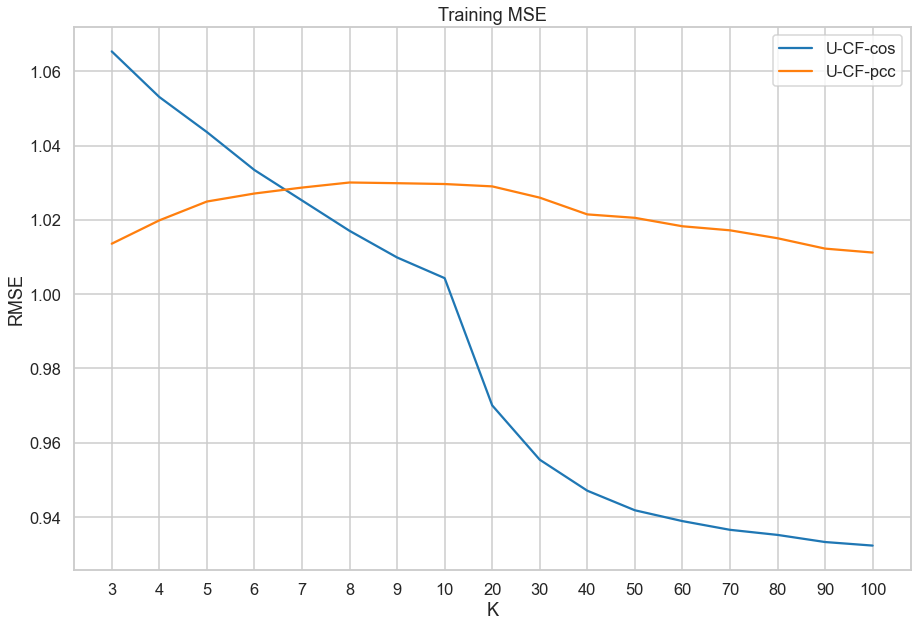

In [196]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_cos, "U-CF-pcc":ucf_pcc})
# Visualize
plot_result(df, "Training MSE")

## 1.2. Item-based Collaborative Filtering (I-CF)

In [197]:
# Transpose user_matrix as movie_matrix, bias_matrix as movie_bias.
movie_matrix = user_matrix.T
movie_bias = bias_matrix.T
movie_matrix.shape, movie_bias.shape

((1682, 943), (1682, 943))

#### ＃電影校正後會產生zero vec故在這裡不採用校正後matrix算相似度 

In [188]:
# 計算電影平均評分
movie_mean = non_zero_mean(movie_matrix)
# 使用個別電影平均校正電影對使用者的評分
# movie_adjust = np.where(movie_matrix == 0, movie_matrix, movie_matrix-movie_mean)
movie_adjust = movie_matrix - np.mean(movie_matrix, axis=1).reshape(-1, 1)
print(f"movie_matrix:\n{movie_matrix} \n\nafter adjust:\n{movie_adjust}")

movie_matrix:
[[0. 4. 0. ... 5. 0. 0.]
 [3. 0. 0. ... 0. 0. 5.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

after adjust:
[[-1.30965005e+00  2.69034995e+00 -1.30965005e+00 ...  3.69034995e+00
  -1.30965005e+00 -1.30965005e+00]
 [ 2.67020148e+00 -3.29798515e-01 -3.29798515e-01 ... -3.29798515e-01
  -3.29798515e-01  4.67020148e+00]
 [ 3.78685048e+00 -2.13149523e-01 -2.13149523e-01 ... -2.13149523e-01
  -2.13149523e-01 -2.13149523e-01]
 ...
 [-2.12089077e-03 -2.12089077e-03 -2.12089077e-03 ... -2.12089077e-03
  -2.12089077e-03 -2.12089077e-03]
 [-3.18133616e-03 -3.18133616e-03 -3.18133616e-03 ... -3.18133616e-03
  -3.18133616e-03 -3.18133616e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [198]:
# 取得movie間的相似度名單
cos_mdict, pcc_mdict = get_sim_dict(movie, movie_matrix)

caculator u & v similar: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [02:43<00:00, 10.30it/s]


### 1.2.1.  Item‐Based CF use Cosine result

In [199]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_cos = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(cos_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,cos_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_mdict[i].index, heapq.nlargest(k,cos_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_matrix[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Siv = copy.deepcopy(Siv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_matrix[j, u] == 0:
                        R.append(0)
                        copy_Siv[c] = 0
                    else:
                        R.append(movie_matrix[j, u] - movie_bias[j, u])

                # 預測使用者u對於第m部電影的評分
                Riu = predict(Siv, R) + movie_bias[i, u]
                # predict_matrix[i, u] = Riu
                # 計算RMSE
                delta_list.append(se(rth, Riu))
    icf_cos.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:12<00:00, 137.87it/s]


### 1.2.2.  Item‐Based CF use Pearson Correlation Coefficient result

In [200]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_pcc = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(pcc_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,pcc_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_mdict[i].index, heapq.nlargest(k,pcc_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_matrix[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Siv = copy.deepcopy(Siv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_matrix[j, u] == 0:
                        R.append(0)
                        copy_Siv[c] = 0
                    else:
                        R.append(movie_matrix[j, u] - movie_bias[j, u])

                # 預測使用者u對於第m部電影的評分
                Riu = predict(Siv, R) + movie_bias[i, u]
                # predict_matrix[i, u] = Riu
                # 計算RMSE
                delta_list.append(se(rth, Riu))
    icf_pcc.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:12<00:00, 131.96it/s]


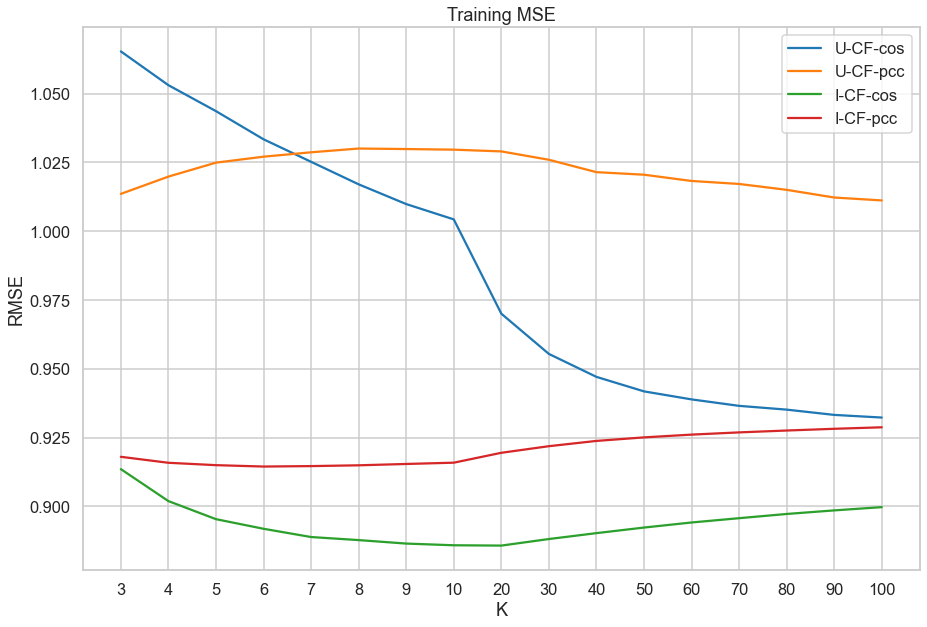

In [201]:
# numpy to pandas
df["I-CF-cos"] = icf_cos
df["I-CF-pcc"] = icf_pcc
# Visualize
plot_result(df, "Training MSE")

## 1.3. Testing U-CF

In [ ]:
# init user_matrix as zero matrix
user_testing = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = test_data[test_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_testing[u-1, rate-1] = test_data[(test_data[:,0] == u) & (test_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:02<00:00, 397.09it/s]


In [ ]:
training = True

if training:
    print("Array Exist!!")

else:
    # 若bias不存在，則計算training bias
    print("Calculating Bias...")
    bias_matrix = get_bias(user_matrix)

    # 取得user間的相似度名單
    # 計算使用者平均評分
    user_mean = non_zero_mean(user_matrix)
    # # 使用個別使用者平均校正使用者對電影的評分
    # user_adjust = np.where(user_matrix == 0, user_matrix, user_matrix-user_mean)
    # print(f"user_matrix:\n{user_matrix} \n\nafter adjust:\n{user_adjust}")

    cos_dict, pcc_dict = get_sim_dict(user, user_matrix)

Calculating Bias...


caculator u & v similar: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:03<00:00, 14.85it/s]


### 1.3.1. Testing U-CF-cos

In [ ]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_tcos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_testing[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_testing[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_testing[j, m] - bias_matrix[j, m])

            # # R: 相似使用者對調整後電影 m 的評分
            # R = [user_testing[:,m][j] - bias_matrix[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
            Rui = predict(Suv, R) + bias_matrix[i, m]
            # predict_matrix[i, m] = Rui
            # 計算RMSE
            delta_list.append(se(rth, Rui))
    ucf_tcos.append(rmse(delta_list))

predicting K = 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:27<00:00, 34.33it/s]


### 1.3.2. Testing U-CF-pcc

In [ ]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_tpcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_testing[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_testing[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_testing[j, m] - bias_matrix[j, m])
                        
            # # R: 相似使用者對調整後電影 m 的評分
            # R = [user_testing[:,m][j] - bias_matrix[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
            Rui = predict(Suv, R) + bias_matrix[i, m]
            # predict_matrix[i, m] = Rui
            # 計算RMSE
            delta_list.append(se(rth, Rui))
    ucf_tpcc.append(rmse(delta_list))

predicting K = 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:27<00:00, 34.13it/s]


## 1.4. Testing I-CF

In [ ]:
movie_testing = user_testing.T

# 取得 bias
if training:
    print("Array Exist!!")

else:
    print("getting movie bias...")
    # Transpose user_matrix as movie_matrix, bias_matrix as movie_bias.
    movie_bias = bias_matrix.T
    
    # 取得movie間的相似度名單
    print("getting similarity...")
    cos_mdict, pcc_mdict = get_sim_dict(movie, movie_matrix)

getting movie bias...
getting similarity...


caculator u & v similar: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [02:38<00:00, 10.59it/s]


### 1.4.1. Testing I-CF-cos

In [ ]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_tcos = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(cos_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,cos_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_mdict[i].index, heapq.nlargest(k,cos_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_testing[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_testing[j, u] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(movie_testing[j, u] - movie_bias[j, u])
                        
            # # R: 相似電影對調整後使用者 u 的評分
            # R = [movie_testing[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            # predict_matrix[i, u] = Riu
            # 計算RMSE
            delta_list.append(se(rth, Riu))
    icf_tcos.append(rmse(delta_list))

predicting K = 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:28<00:00, 60.02it/s]


### 1.4.2. Testing I-CF-pcc

In [ ]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_tpcc = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(pcc_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,pcc_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_mdict[i].index, heapq.nlargest(k,pcc_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_testing[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_testing[j, u] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(movie_testing[j, u] - movie_bias[j, u])
                        
            # # R: 相似電影對調整後使用者 u 的評分
            # R = [movie_testing[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            # predict_matrix[i, u] = Riu
            # 計算RMSE
            delta_list.append(se(rth, Riu))
    icf_tpcc.append(rmse(delta_list))

predicting K = 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:28<00:00, 58.64it/s]


## 1.5. Training & Testing Result

In [ ]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df_test = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_tcos, "U-CF-pcc":ucf_tpcc, "I-CF-cos":icf_tcos, "I-CF-pcc":icf_tpcc})
df_test

,K,U-CF-cos,U-CF-pcc,I-CF-cos,I-CF-pcc
0,3,1.165222,1.013305,1.203750,0.975543
1,4,1.135065,0.998575,1.174316,0.965153
2,5,1.114338,0.985319,1.156180,0.960296
3,6,1.102331,0.978725,1.139073,0.958294
4,7,1.093507,0.969437,1.128360,0.955801
5,8,1.084284,0.964698,1.119274,0.952430
6,9,1.078564,0.961137,1.112424,0.950516
7,10,1.072028,0.959319,1.106573,0.948829
8,20,1.044643,0.946539,1.077959,0.941421
9,30,1.033799,0.940997,1.065221,0.938040


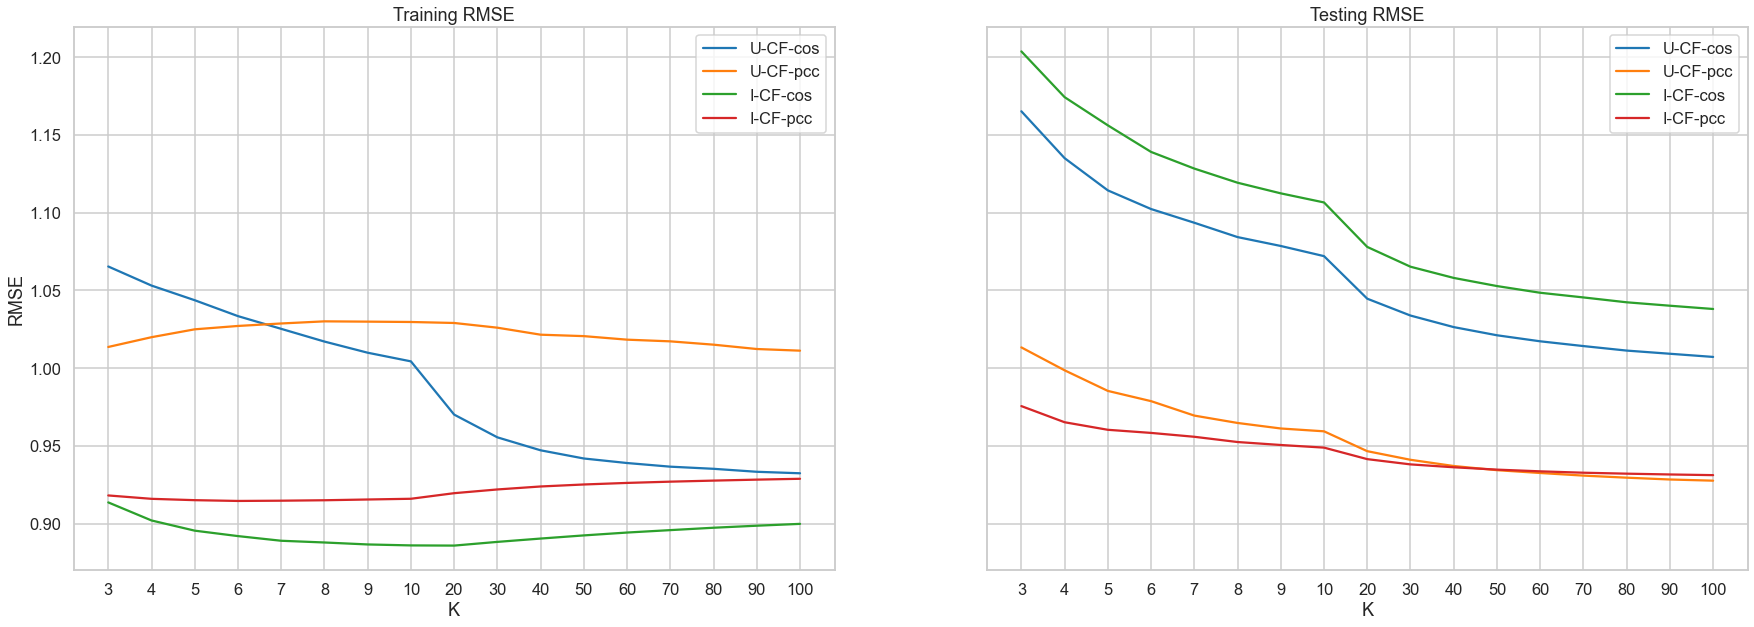

In [ ]:
fig,axes=plt.subplots(1,2, figsize=(30,10), sharey=True)
plot_training_testing(df, axes[0], "Training RMSE")
plot_training_testing(df_test, axes[1], "Testing RMSE")

# 2. Latent Factor Model (Matrix Factorization)

In [10]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])

# 訓練資料及測試資料
train_data.shape, test_data.shape

((75000, 4), (25000, 4))

In [11]:
# init user_matrix as zero matrix
user_item = np.zeros((len(user), len(movie)))

# 將資料轉成矩陣形式
for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_item[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:20<00:00, 46.67it/s]


In [70]:
def test(test_data, p, q, gu=False, bu=False, bi=False):
    rmse_test = list()

    for test in test_data:
        user = test[0] - 1
        movie = test[1] - 1
        # 判斷是否有bias
        if gu and bu and bi:
            rmse_test.append(se(test[2], (np.dot(p[user], q[movie]) + gu + bu[user] + bi[movie])))
        else:
            rmse_test.append(se(test[2], (np.dot(p[user], q[movie]))))
    return rmse(rmse_test)

# Vistualize Result
def plot_latent(df, x):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.figure(figsize=(20,8))
    for c in df.columns:
        if c != x:
            g = sns.lineplot(data=df, x=x, y=c, label=c)
    g.set(ylabel = "RMSE")

## 2.1. Initialize latent matrix

In [160]:
# init lentent vector
K = 20
# init user lentent matrix
P = np.random.uniform(low=0, high=3, size=(len(user), K))
# init movie lentent matrix
Q = np.random.uniform(low=0, high=3, size=(len(movie), K))
# init user lentent matrix(nobias)
NP = np.random.uniform(low=0, high=3, size=(len(user), K))
# init movie lentent matrix(nobias)
NQ = np.random.uniform(low=0, high=3, size=(len(movie), K))

## 2.2. Use SGD optimization algorithm update latent matrix

In [13]:
# 設定SGD learning_rate
alpha = 0.01
# 設定正則化參數
l = 0.1
# epochs setting
epochs = 100

### 2.2.1. Nobias

In [158]:
MF_nobias_training = list()
MF_nobias_testing = list()

for epoch in range(epochs):
    rmse_list = list()
    # 針對user有評分過的rating位置進行更新(User Latent Matrix)
    for j in range(len(user)):
        # 找出使用者j對哪幾部電影評分的index
        movie_index = [i for i, e in enumerate(user_item[j]) if e != 0]
        for m in movie_index:
            # 若user item 有值則對Q的相對欄位進行SGD更新, 將更新後user latent matrix先暫存
            tmp = NQ[m] - alpha * ((np.dot(NP[j], NQ[m]) - user_item[j,m]) * NP[j] + l*(NQ[m]))
            # 更新 movie latent matrix
            NP[j] -= alpha * ((np.dot(NP[j], NQ[m]) - user_item[j,m]) * NQ[m] + l*(NP[j]))
            # 更新 user latent matrix
            NQ[m] = tmp
            # 計算ＳＥ
            rmse_list.append(se(user_item[j, m], np.dot(NP[j], NQ[m])))
    
    MF_nobias_training.append(rmse(rmse_list))
    # 進行驗證資料測試
    MF_nobias_testing.append(test(test_data, NP, NQ))
    if epoch % 9 == 0:
        print(f"epoch={epoch}, trainging={MF_nobias_training[-1]}, testing={MF_nobias_testing[-1]}")

epoch=0, trainging=1.8001772469504627, testing=4.0422336829187575
epoch=9, trainging=0.6287348994639808, testing=1.3677740503742313
epoch=18, trainging=0.6177226437282037, testing=1.1817049289370094
epoch=27, trainging=0.6086645442070204, testing=1.0968647131032148
epoch=36, trainging=0.5995468593934118, testing=1.0518424513342541
epoch=45, trainging=0.5915305323813782, testing=1.026373576976324
epoch=54, trainging=0.584818512106063, testing=1.011157902676769
epoch=63, trainging=0.5792717297956946, testing=1.0015255180754716
epoch=72, trainging=0.5746877056801235, testing=0.9950582598373516
epoch=81, trainging=0.5708802571647944, testing=0.990476096999477
epoch=90, trainging=0.5676964364730426, testing=0.9870808529052161
epoch=99, trainging=0.5650147061711426, testing=0.9844756716237384


### 2.2.2. Having Bias

In [56]:
MF_bias_training = list()
MF_bias_testing = list()
# init setting global mean
gu= get_u()
# init setting user mean as bias
bu = [get_ubias(i) - gu for i in range(len(user))] 
# init setting movie mean as bias
bi = [get_ibias(m) - gu for m in range(len(movie))] 

for epoch in range(epochs):
    rmse_list = list()
    # 針對user有評分過的rating位置進行更新(User Latent Matrix)
    for j in range(len(user)):
        # 找出使用者j對哪幾部電影評分的index
        movie_index = [i for i, e in enumerate(user_item[j]) if e != 0]
        for m in movie_index:
            # 對u 做偏微分進行ＳＧＤ更新
            tmp_gu = gu - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(gu))
            # 對bu 做偏微分進行ＳＧＤ更新
            tmp_bu = bu[j] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(bu[j]))
            # 對bi 做偏微分進行ＳＧＤ更新
            tmp_bi = bi[m] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(bi[m]))
            # 若user item 有值則對Q的相對欄位進行SGD更新, 將更新後user latent matrix先暫存
            tmp = Q[m] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) * P[j] + l*(Q[m]))
            # 更新 movie latent matrix
            P[j] -= alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) * Q[m] + l*(P[j]))
            # 更新 user latent matrix
            Q[m] = tmp
            # 更新bias
            gu = tmp_gu
            bu[j] = tmp_bu
            bi[m] = tmp_bi
            # 計算ＳＥ
            rmse_list.append(se(user_item[j, m], (np.dot(P[j], Q[m]) + gu + bu[j] + bi[m])))
    MF_bias_training.append(rmse(rmse_list))
    # 進行驗證資料測試
    MF_bias_testing.append(test(test_data, P, Q, gu, bu, bi))
    if epoch % 9 == 0:
        print(f"epoch={epoch}, gu={gu}, bu={np.mean(bu)}, bi={np.mean(bi)}, training={MF_bias_training[-1]}, testing={MF_bias_testing[-1]}")

epoch=0, gu=-9.370793279313942, bu=-0.6476141057352623, bi=-0.9279403758652923, training=1.267928034112335, testing=9.89922423691281
epoch=9, gu=0.8922032140073325, bu=-0.0050049809782474084, bi=-0.5793962739216707, training=0.771622620800976, testing=1.240836187398587
epoch=18, gu=0.8798134249239599, bu=0.2522423690283363, bi=-0.444723947963059, training=0.7582561038794315, testing=1.091295221461148
epoch=27, gu=0.8949522021737343, bu=0.40972769658008357, bi=-0.3630207903535454, training=0.7419341316374009, testing=1.0360080769583309
epoch=36, gu=0.9055913991653105, bu=0.5228555499145784, bi=-0.3023153922443184, training=0.7264313498246759, testing=1.006837241937323
epoch=45, gu=0.9127196030278837, bu=0.6075673584302681, bi=-0.25281743177940785, training=0.7127733394147955, testing=0.989275074217344
epoch=54, gu=0.9186539690827813, bu=0.6722216119574194, bi=-0.21019943985170775, training=0.7007661728711018, testing=0.977455908602907
epoch=63, gu=0.9239176929297502, bu=0.72227827185808

## 2.3. Vistualize Result

In [64]:
# numpy to pandas
latent_iteration = pd.DataFrame({"Iteration": [i for i in range(1, 100+1)],
                                 "MF-nobias (training)": MF_nobias_training,
                                 "MF-nobias (testing)": MF_nobias_testing,
                                 "MF-bias (training)": MF_bias_training,
                                 "MF-bias (testing)": MF_bias_testing
                                })


### 2.3.1 Varying the iteration number

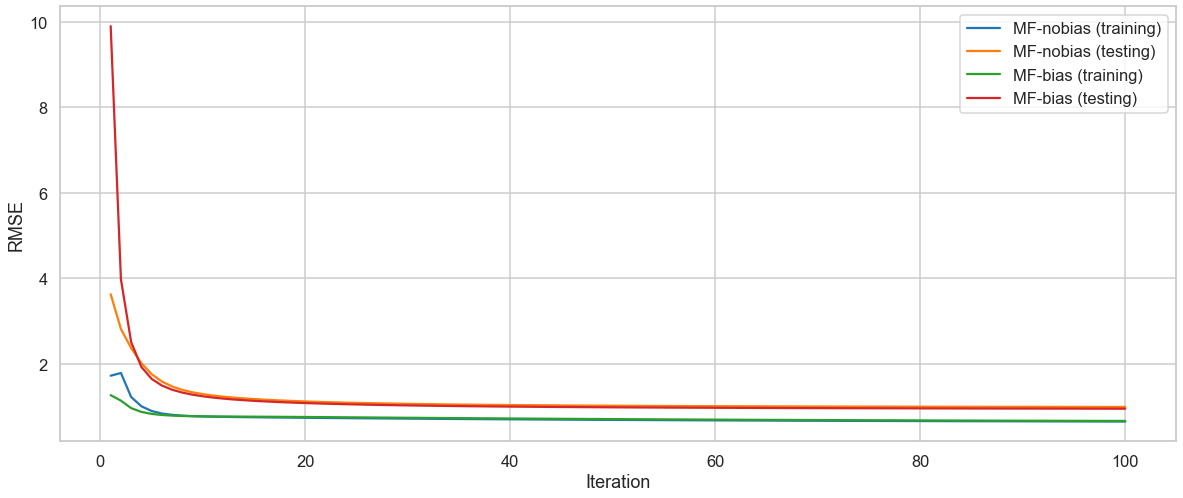

In [71]:
# Visualize
plot_latent(latent_iteration, "Iteration")

### 2.3.2. Varying the number of latent factors

In [166]:
# setting the number of latent factors
LK = [ i for i in range(5, 100+1, 5)]

_MF_bias_training = list()
_MF_bias_testing = list()
_MF_nobias_training = list()
_MF_nobias_testing = list()

# 搜集不同Ｋ經過100次迴圈所產生的ＲＭＳＥ結果
for k in LK:
    # init lentent vector
    K = k
    # init user lentent matrix
    P = np.random.uniform(low=0, high=2, size=(len(user), K))
    # init movie lentent matrix
    Q = np.random.uniform(low=0, high=2, size=(len(movie), K))
    # init user lentent matrix(nobias)
    NP = np.random.uniform(low=0, high=2, size=(len(user), K))
    # init movie lentent matrix(nobias)
    NQ = np.random.uniform(low=0, high=2, size=(len(movie), K))
    
    # having bias setting
    # init setting global mean
    gu= get_u()
    # init setting user mean as bias
    bu = [get_ubias(i) - gu for i in range(len(user))] 
    # init setting movie mean as bias
    bi = [get_ibias(m) - gu for m in range(len(movie))] 
    
    ######### nobias ############
    for epoch in tqdm(range(epochs), desc=f"K={K}"):
        rmse_list = list()
        bias_rmse_list = list()
        # 針對user有評分過的rating位置進行更新(User Latent Matrix)
        for j in range(len(user)):
            # 找出使用者j對哪幾部電影評分的index
            movie_index = [i for i, e in enumerate(user_item[j]) if e != 0]
            for m in movie_index:
                # 若user item 有值則對Q的相對欄位進行SGD更新, 將更新後user latent matrix先暫存
                tmp = NQ[m] - alpha * ((np.dot(NP[j], NQ[m]) - user_item[j,m]) * NP[j] + l*(NQ[m]))
                # 更新 movie latent matrix
                NP[j] -= alpha * ((np.dot(NP[j], NQ[m]) - user_item[j,m]) * NQ[m] + l*(NP[j]))
                # 更新 user latent matrix
                NQ[m] = tmp
                if epoch == 99:
                    # 計算ＳＥ
                    rmse_list.append(se(user_item[j, m], np.dot(NP[j], NQ[m])))
    ######### having bias ############
                # 對u 做偏微分進行ＳＧＤ更新
                tmp_gu = gu - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(gu))
                # 對bu 做偏微分進行ＳＧＤ更新
                tmp_bu = bu[j] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(bu[j]))
                # 對bi 做偏微分進行ＳＧＤ更新
                tmp_bi = bi[m] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) + l*(bi[m]))
                # 若user item 有值則對Q的相對欄位進行SGD更新, 將更新後user latent matrix先暫存
                tmp = Q[m] - alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) * P[j] + l*(Q[m]))
                # 更新 movie latent matrix
                P[j] -= alpha * (((np.dot(P[j], Q[m]) + gu + bu[j] + bi[m]) - user_item[j,m]) * Q[m] + l*(P[j]))
                # 更新 user latent matrix
                Q[m] = tmp
                # 更新bias
                gu = tmp_gu
                bu[j] = tmp_bu
                bi[m] = tmp_bi
                if epoch == 99:
                    # 計算ＳＥ
                    bias_rmse_list.append(se(user_item[j, m], (np.dot(P[j], Q[m]) + gu + bu[j] + bi[m])))
                    
        if epoch == 99:
            _MF_nobias_training.append(rmse(rmse_list))
            # 進行驗證資料測試
            _MF_nobias_testing.append(test(test_data, NP, NQ))
            print(f"Nobias: K={K}, trainging={_MF_nobias_training[-1]}, testing={_MF_nobias_testing[-1]}")
            
            _MF_bias_training.append(rmse(bias_rmse_list))
            # 進行驗證資料測試
            _MF_bias_testing.append(test(test_data, P, Q, gu, bu, bi))
            print(f"Bias: K={K}, gu={gu}, bu={np.mean(bu)}, bi={np.mean(bi)}, training={_MF_bias_training[-1]}, testing={_MF_bias_testing[-1]}")

K=0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


Nobias: K=0, trainging=3.70456115259734, testing=3.706324324718494
Bias: K=0, gu=1.1811261868361886, bu=1.197450655680285, bi=0.6373763845243926, training=0.9011936755050223, testing=0.9734290095900086


K=5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


Nobias: K=5, trainging=0.7696684673740791, testing=0.9505270961636066
Bias: K=5, gu=0.9574738071236988, bu=0.8947159530817573, bi=0.21137685480111798, training=0.7771629105030491, testing=0.9407364251100186


K=10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


Nobias: K=10, trainging=0.7103080218570598, testing=0.9528886219212066
Bias: K=10, gu=0.9277640912658215, bu=0.8635587443510262, bi=0.12135362284159837, training=0.7223763565980157, testing=0.9448427386668983


K=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:46<00:00,  4.66s/it]


Nobias: K=15, trainging=0.6728605225842084, testing=0.9636806151916772
Bias: K=15, gu=0.9195239739497286, bu=0.8491752070977914, bi=0.06231733051853856, training=0.6839550791969166, testing=0.9436033507299805


K=20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:36<00:00, 38.16s/it]


Nobias: K=20, trainging=0.646930814164387, testing=0.9690644138282642
Bias: K=20, gu=0.9167156914377734, bu=0.8391314350180163, bi=0.022963767892949346, training=0.6582316716598365, testing=0.9391749815545501


K=25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


Nobias: K=25, trainging=0.6246789535451778, testing=0.9735027429821734
Bias: K=25, gu=0.9112420068662821, bu=0.8330191285910589, bi=-0.0003068573205312945, training=0.6384392487551641, testing=0.939203120944898


K=30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


Nobias: K=30, trainging=0.6128843154753085, testing=0.9716464150631731
Bias: K=30, gu=0.9194939396598995, bu=0.8286567068716483, bi=-0.026788842196439146, training=0.624320237842303, testing=0.9392026342588745


K=35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Nobias: K=35, trainging=0.6001668713514465, testing=0.976452584567707
Bias: K=35, gu=0.9173085667331007, bu=0.8277846460094376, bi=-0.035838985290223446, training=0.6116105589512845, testing=0.9457231849438561


K=40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Nobias: K=40, trainging=0.5917934995273699, testing=0.9812412656979785
Bias: K=40, gu=0.9140365683000788, bu=0.825604700190519, bi=-0.042095635024320344, training=0.6045426227609202, testing=0.9416944667129732


K=45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


Nobias: K=45, trainging=0.5836713101776371, testing=0.9785997767393634
Bias: K=45, gu=0.9219640000418562, bu=0.8274284319678235, bi=-0.0473166710191901, training=0.5978113908299152, testing=0.9462937121604382


K=50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


Nobias: K=50, trainging=0.5792679533599469, testing=0.976414853297908
Bias: K=50, gu=0.9233838328538908, bu=0.828049319222053, bi=-0.04457121266126727, training=0.592994149491067, testing=0.9432586151448473


K=55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


Nobias: K=55, trainging=0.5744674731587396, testing=0.9789630870382603
Bias: K=55, gu=0.9253192954291276, bu=0.8297903642215482, bi=-0.043317594847113866, training=0.587127973842539, testing=0.9451986118897147


K=60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


Nobias: K=60, trainging=0.5707853026475243, testing=0.9812857712974369
Bias: K=60, gu=0.931006407939358, bu=0.8317403389465723, bi=-0.04022218657678747, training=0.5843398739172637, testing=0.9450142165089991


K=65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


Nobias: K=65, trainging=0.5680022710697836, testing=0.9773726824383322
Bias: K=65, gu=0.9299255272735155, bu=0.8352243423909536, bi=-0.03469387962480484, training=0.581952418512194, testing=0.94941419540253


K=70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


Nobias: K=70, trainging=0.5658192911680312, testing=0.9801424254740452
Bias: K=70, gu=0.9284630427055395, bu=0.8353587270646268, bi=-0.028119803443363785, training=0.5788492687912188, testing=0.9469302602365065


K=75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Nobias: K=75, trainging=0.5628583959968664, testing=0.9765497432563233
Bias: K=75, gu=0.9388876941542021, bu=0.8396601124502675, bi=-0.019997099491810347, training=0.5770024573647495, testing=0.9461254150083863


K=80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Nobias: K=80, trainging=0.5612076272662998, testing=0.9777661915228221
Bias: K=80, gu=0.9323461471989326, bu=0.8416344078875022, bi=-0.011698618075871855, training=0.5753987000616548, testing=0.9463892778656924


K=85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


Nobias: K=85, trainging=0.5592735246134759, testing=0.9758213106696813
Bias: K=85, gu=0.927285948578725, bu=0.8472470589096848, bi=-0.0011700410956759896, training=0.574209095265937, testing=0.9443011820708347


K=90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


Nobias: K=90, trainging=0.5580056100887136, testing=0.9831103653242166
Bias: K=90, gu=0.9360356355393805, bu=0.8521701006022198, bi=0.004394088839161305, training=0.5727109397257857, testing=0.9468417898417233


K=95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


Nobias: K=95, trainging=0.5571319253619551, testing=0.9709385963839234
Bias: K=95, gu=0.9379045256105604, bu=0.856994200738932, bi=0.01605528535815996, training=0.5718651960022961, testing=0.9447195259207573


K=100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]

Nobias: K=100, trainging=0.5560266107669721, testing=0.9731434599777568
Bias: K=100, gu=0.9395772229066601, bu=0.8642923883735176, bi=0.027283141261001755, training=0.5702743319856803, testing=0.9438512726906352


In [180]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), LK))

# numpy to pandas
latent_k = pd.DataFrame({"Number of latent factor k": str_k,
                                 "MF-nobias (training)": _MF_nobias_training,
                                 "MF-nobias (testing)": _MF_nobias_testing,
                                 "MF-bias (training)": _MF_bias_training,
                                 "MF-bias (testing)": _MF_bias_testing
                                })

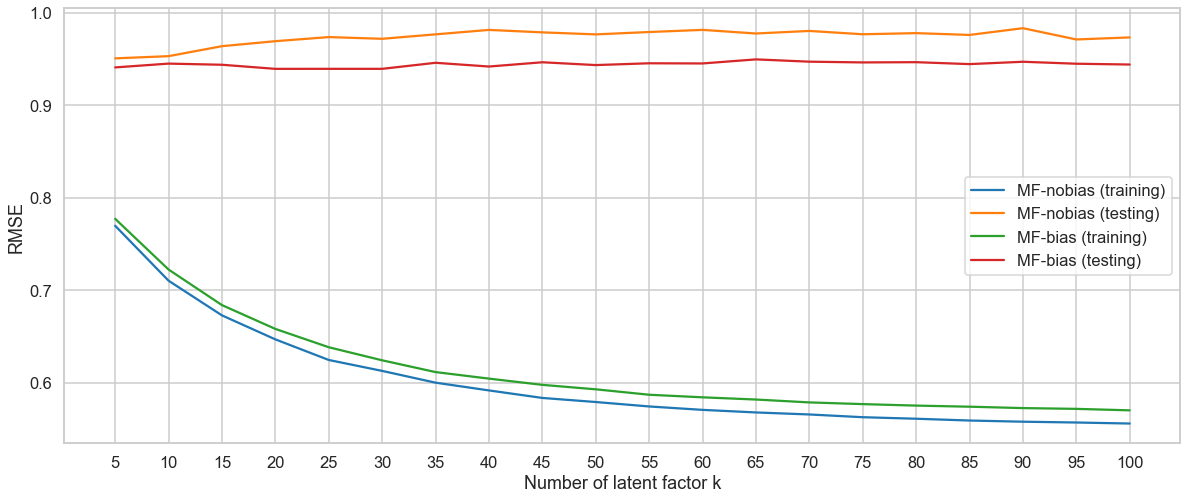

In [181]:
# Visualize
plot_latent(latent_k, "Number of latent factor k")

# 3. Report the Perforemance

In [202]:
# Default Parameters
ucf_pcc_default = ucf_tpcc[3]
ucf_cos_default = ucf_tcos[3]
icf_pcc_default = icf_tpcc[3]
icf_cos_default = icf_tcos[3]
mf_bias_default = MF_bias_testing[-1]
mf_nobias_default = MF_nobias_testing[-1]

# Turned Parameters
ucf_pcc_tuned = min(ucf_tpcc)
ucf_cos_tuned = min(ucf_tcos)
icf_pcc_tuned = min(icf_tpcc)
icf_cos_tuned = min(icf_tcos)
mf_bias_tuned = min(_MF_bias_testing)
mf_nobias_tuned = min(MF_bias_testing)

In [224]:
# create data
d = [
    ["U-CF-pcc", "Default Parameters", ucf_pcc_default],
    ["U-CF-cos", "Default Parameters", ucf_cos_default],
    ["I-CF-pcc", "Default Parameters", icf_pcc_default],
    ["I-CF-cos", "Default Parameters", icf_cos_default],
    ["MF-nobias", "Default Parameters", ucf_pcc_default],
    ["MF-bias", "Default Parameters", mf_bias_default],
    
    ["U-CF-pcc", "Tuned Parameters", ucf_pcc_tuned],
    ["U-CF-cos", "Tuned Parameters", ucf_cos_tuned],
    ["I-CF-pcc", "Tuned Parameters", icf_pcc_tuned],
    ["I-CF-cos", "Tuned Parameters", icf_cos_tuned],
    ["MF-nobias", "Tuned Parameters", ucf_pcc_tuned],
    ["MF-bias", "Tuned Parameters", mf_bias_tuned],
]
performance = pd.DataFrame(d, columns=["method","type","RMSE"])

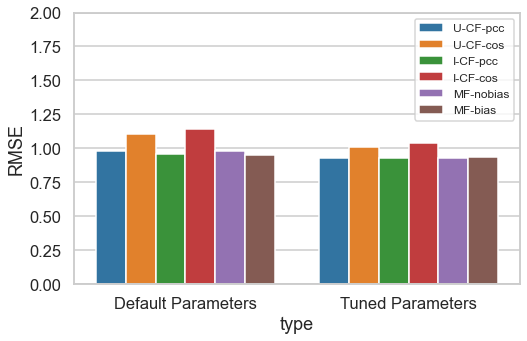

In [225]:
plt.figure(figsize=(8,5))
plt.ylim(0,2)
sns.barplot(x="type", y="RMSE", hue="method", data=performance)
plt.legend(loc="upper right", prop={'size':12})